In [1]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from matplotlib import rc

# Q1
Solving Kepler's equation using Newton's Method:

In [2]:
def solve_kepler(e, M):
    """
    Solve Kepler's Equation M = E - e sinE
    """ 
    dEs = []
    E = M + 0.85 * e * np.sign(np.sin(M))
    dE = 1e3
    while abs(E - e * np.sin(E) - M) > 1e-10:
        dE = ((E - e * np.sin(E) - M)) / (1 - e * np.cos(E))
        E -= dE
    return E
        
    

Verify over $0 < e < 1$ and $0 < M < 2\pi$ that Kepler's equation holds down to an error of $10^{-10}$

In [3]:
e = np.random.random(size=10000)
M = 2 * np.pi * np.random.random(size=10000)

for e, M in zip(e, M):
    E = solve_kepler(e, M)
    assert(M - (E - e * np.sin(E)) < 1e-10)

None of the assertions failed, so our solver seems to do the job!

# Q2
Calculate radial velocity given six parameters: $(K_{star}, P, t_p, e, \omega, \gamma)$

In [4]:
def true_anomaly(e, M):
    E = solve_kepler(e, M)
    return 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))

In [37]:
def RV_model(t, K_star, P, tp, e, omega, gamma):
    # if t is an array like object
    if np.ndim(t)!=0:
        RVs = []
        for tt in t:
            M = 2 * np.pi / P * (tt - tp)
            f = true_anomaly(e, M)
            RVs.append(K_star * (np.cos(omega) * np.cos(f) - np.sin(omega) * np.sin(f) + e * np.cos(omega)) + gamma)
        return RVs
    # if t is a float
    M = 2 * np.pi / P * (t - tp)
    f = true_anomaly(e, M)
    return K_star * (np.cos(omega) * np.cos(f) - np.sin(omega) * np.sin(f) + e * np.cos(omega)) + gamma


# Q3
To find the period of the mystery planet we will use a Lomb Scargle Periodogram. First, loading in the data:

In [6]:
# Read in data
df = pd.read_csv('mystery_planet01.txt', delim_whitespace=True, header=None, names=['t', 'rv', 'rv_err'])
df['t'] = df['t'] - df['t'].min() # begin time at first obs
df.head()

,t,rv,rv_err
0,0.000,-0.125,0.014
1,24.952,0.143,0.015
2,214.831,-0.110,0.012
3,215.842,-0.123,0.012
4,216.847,-0.129,0.012


Then some combination of arguments passed into astropy's LombScargle model seems to do the trick...

(0.0, 0.01)

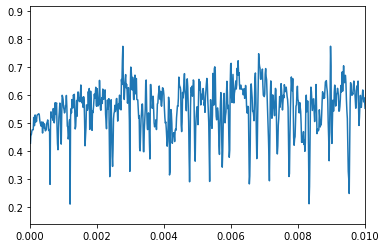

In [7]:
freq, power = LombScargle(df['t'], df['rv'], df['rv_err'], nterms=10).autopower(nyquist_factor=4, samples_per_peak=20)

# plot frequency vs power
plt.plot(freq, power)
plt.xlim([0,.01])

Getting the frequency (in $days^{-1}) with maximum power:

In [8]:
f = freq[np.argmax(power)]
f

0.01794830591244739

We plot the folded timeseries to verify if this is the correct frequency

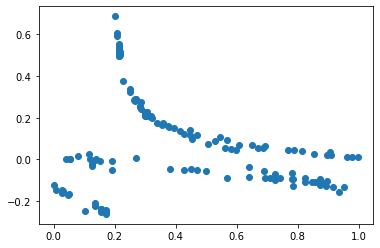

In [9]:
P = 1/(f)
plt.scatter((df['t']%P)/P, df['rv'])

Hmmm close, but not good enough. Try the next harmonic

In [10]:
P = 2/(f)

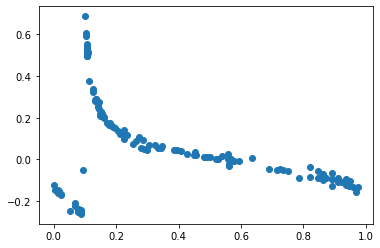

In [11]:
plt.scatter((df['t']%P)/P, df['rv'])

In [12]:
P

111.4311294757336

Much better :) the period is approximately 111.43 days

# Q4
Using an MCMC to fit the parameters: $(K_{star}, P, t_p, e, \omega, \gamma)$:

In [13]:
import emcee

In [29]:
def log_likelihood(theta, t, rv, rv_err):
    # return gaussian log likelihood of data given model params theta
    K_star, P, tp, e, omega, gamma = theta
    model = RV_model(t, K_star, P, tp, e, omega, gamma)
    sigma2 = rv_err ** 2 
    return -0.5 * np.sum((rv - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    # return -inf if params outside of priors, else return 0
    K_star, P, tp, e, omega, gamma = theta
    if .2 < K_star < .7 and 110 < P < 113 and 0 < tp < 113 and 0 < e < 1 and 0 < omega < 6.29 and -1 < gamma < 1:
        return 0.0
    return -np.inf

def log_probability(theta, t, rv, rv_err):
    # sum of logL and log Priors
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, rv, rv_err)

Using chi-by-eye, I determined an initial guess of parameters

In [25]:
solve_kepler(.5, 2.5)

2.709421610927704

In [39]:
RV_model(0, .5, .5, .5, .5, .5, .5)

1.1581869214177791

In [38]:
RV_model(df['t'], .5, .5, .5, .5, .5, .5)

[1.1581869214177791,
 0.966567099312005,
 0.41390734364919196,
 0.439893210046792,
 0.4525733730184206,
 0.3293271703427664,
 0.34055634322869854,
 0.2446360642352861,
 0.24785390589082573,
 0.28532455912576926,
 0.2841290083381446,
 0.40944408671151705,
 0.21990879749860892,
 0.5145545585352773,
 0.41194975883579,
 0.4622077316947689,
 0.37658440081283395,
 0.5769748980150219,
 0.8833810936719846,
 0.5884519043318157,
 0.8492857926393569,
 0.7993983153234894,
 0.9005804037616872,
 0.9863953826184503,
 0.917828610430936,
 0.9694167976057184,
 0.9694167976068456,
 0.4474321422138749,
 0.44743214221398653,
 0.4884342266713187,
 0.4855152076933362,
 0.41390734364930465,
 0.34388093631002736,
 0.3841928794029084,
 0.532507194906248,
 0.3541780689430096,
 0.3293271703426083,
 0.21990879749859132,
 0.22006967291578117,
 0.242332432510954,
 0.2529896799947018,
 0.2624677835968418,
 0.23991922763871104,
 0.9580501717177312,
 1.1779360684236175,
 1.2191276319203714,
 1.135701644680737,
 0.95229

In [28]:
# K_star, P, tp, e, omega, gamma
init = [  0.5, 111.5,   9.95,  .97, 5.2,   0]

Run the MCMC

In [30]:
np.random.seed(1)
pos = init + 1e-4 * np.random.randn(16, 6) # initialize starting positions of 16 walkers
nwalkers, ndim = pos.shape

# run MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(df['t'], df['rv'], df['rv_err'])
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:59<00:00, 13.92it/s]


Visualize traces to make sure nothing weird is happening

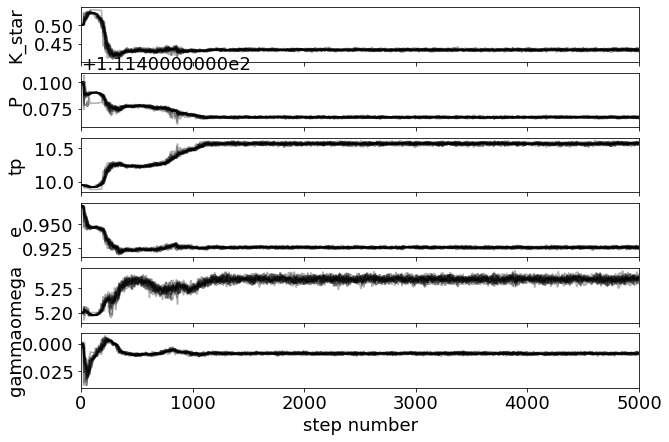

In [31]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['K_star', 'P', 'tp', 'e', 'omega', 'gamma']
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


Looks like it took the MCMC about 1500 steps to converge to the global minimum.

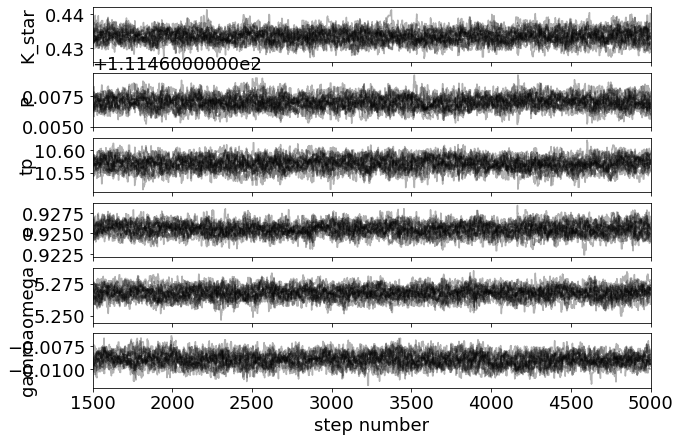

In [32]:
burnin = 1500
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
for i in range(6):
    ax = axes[i]
    ax.plot(range(burnin, burnin + len(samples)), samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(burnin, burnin + len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


The autocorrelations seem a little high and if I were doing research I'd want to modify the step size and thin out the chain before plotting the posterior distributions. However, since this is just for class I'm going to forge ahead.

Make a corner plot: 

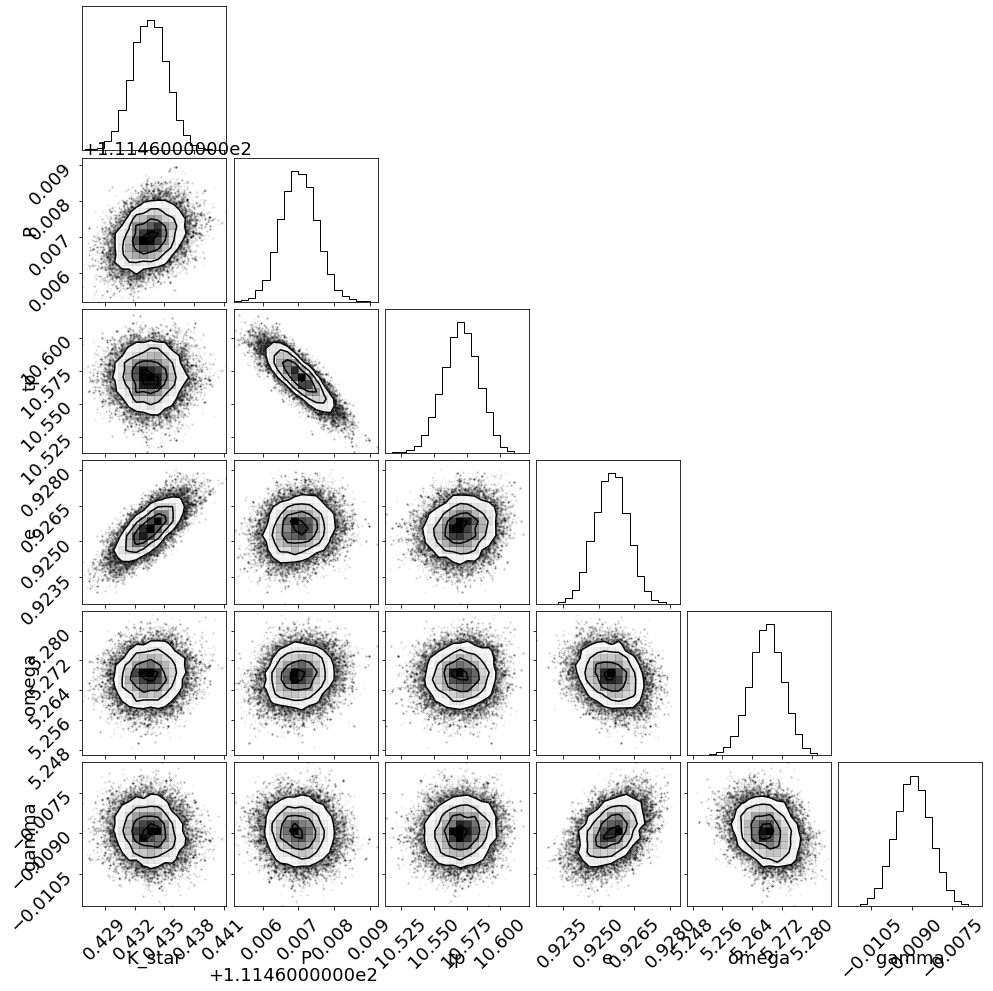

In [33]:
import corner

flat_samples = sampler.get_chain(discard=burnin, flat=True)
fig = corner.corner(
    flat_samples, labels=labels
);

Nice! The distributions look pretty smooth. Note the correlations between some of the parameters! 

The fitted values of $(K_{star}, P, t_p, e, \omega, \gamma)$  are:

In [34]:
fit = flat_samples.mean(axis=0)
fit = np.median(flat_samples, axis=0)
for ii, param in enumerate(fit):
    print(labels[ii].ljust(10), round(param, 3))

K_star     0.433
P          111.467
tp         10.57
e          0.926
omega      5.268
gamma      -0.009


Plotting the model against the data, we see that the model does really well!

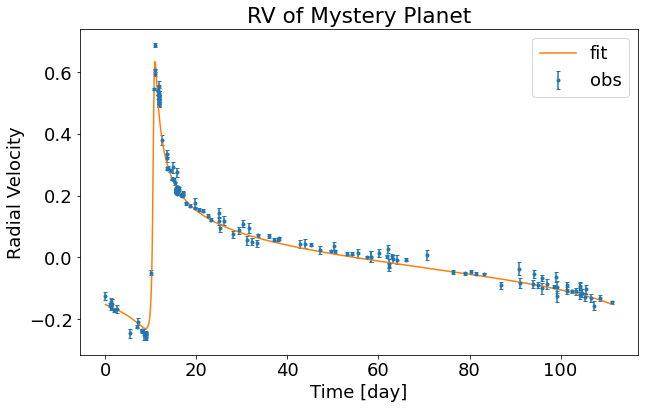

In [35]:
P = fit[1]
font = {'size' : 18}
rc('font', **font)

# plot fit
ts = np.linspace(0, P, 1000)
plt.figure(figsize=(10,6))
plt.title('RV of Mystery Planet')
plt.errorbar(df['t'] % P, df['rv'], df['rv_err'], label='obs', fmt='.', capsize=2)
plt.plot(ts, RV_model(ts, *fit), label='fit')
plt.xlabel('Time [day]')
plt.ylabel('Radial Velocity')
plt.legend()
plt.show()

What an eccentric planetary system ;)

# Q6

Note, in the write up, $\textbf{r} = \textbf{x}$ and $\dot{\textbf{r}} = \textbf{v}$
### a.
Conservation of angular momentum means that cross product of the position and velocity of an object $\textbf{r}\times\dot{\textbf{r}}$ in orbit is conserved and equal to $|h|\hat{z}$ where $\hat{z} = \hat{r}\times\dot{\hat{r}}$ is perpendicular to the plane of orbit. Thus $\textbf{r(t)}\times\dot{\textbf{r(t)}} = \textbf{r}_0\times\dot{\textbf{r}_0}$ for all t as long as there is no change to the orbit. 

Now to prove the relation:
$$ f\dot{g} - g\dot{f} = 1$$
We know that by applying the f and g equations, we can find $\textbf{r(t)}$ and $\dot{\textbf{r(t)}}$ as a function of $\textbf{r}_0$ and $\dot{\textbf{r}_0}$:


$$
\textbf{r} = f \textbf{r}_0 + g \dot{\textbf{r}_0}\\
\dot{\textbf{r}} = \dot{f} \textbf{r}_0 + \dot{g} \dot{\textbf{r}_0}
$$

Taking the cross products of each side:
$$
\textbf{r} \times \dot{\textbf{r}} = (f \textbf{r}_0 + g \dot{\textbf{r}_0}) \times (\dot{f} \textbf{r}_0 + \dot{g} \dot{\textbf{r}_0})
$$
Using the following two identities for the crossproduct:
$$ \textbf{x} \times \textbf{x} = 0 \\ \textbf{x} \times \textbf{y} = - \textbf{y} \times \textbf{x} $$
We can reduce the RHS to:
$$
\textbf{r} \times \dot{\textbf{r}} = (f \textbf{r}_0 + g \dot{\textbf{r}_0}) \times (\dot{f} \textbf{r}_0 + \dot{g} \dot{\textbf{r}_0}) \\
\textbf{r} \times \dot{\textbf{r}} = (f \textbf{r}_0 \times \dot{g} \dot{\textbf{r}_0}) + (g \dot{\textbf{r}_0} \times \dot{f} \textbf{r}_0) \\
\textbf{r} \times \dot{\textbf{r}} = (f \dot{g} + -g \dot{f}) (\textbf{r}_0 \times \dot{\textbf{r}_0})
$$

However, because of conservation of momentum, $\textbf{r}\times\dot{\textbf{r}} = \textbf{r}_0\times\dot{\textbf{r}_0}$, so we are left with:

$$\fbox{$f\dot{g} - g\dot{f} = 1$}
$$

### b.
The f and g functions are:

$
f = \frac{a}{r_0}(\cos(E - E_0) - 1) + 1 \\
g = (t - t_0) + \frac{1}{n}(\sin(E - E_0) - (E - E_0)) \\
\dot{f} = -\frac{a^2}{rr_0} n \sin(E - E_0) \\
\dot{g} = \frac{a}{r}(\cos(E - E_0) - 1) + 1 \\
$ 


We will set our reference frame so that $E_0 = M_0 = 0$ and that $M = n(t-t_0)$ and also pull out factors of $\frac{a}{r_0}$ and $\frac{a}{r}$ out of $f$ and $\dot{g}$ We can rewrite these equations:


$
f = \frac{a}{r_0}(\cos{E} - 1 + \frac{r_0}{a}) \\
g = \frac{1}{n}(M + \sin{E} - E) \\
\dot{f} = -\frac{a^2}{rr_0} n \sin{E} \\
\dot{g} = \frac{a}{r}(\cos{E} - 1) + \frac{r}{a}) \\
$ 

Now solving for $f\dot{g} - g\dot{f}$:

$f\dot{g} - g\dot{f} \\
= [\frac{a}{r_0}(\cos{E} - 1 + \frac{r_0}{a})][\frac{a}{r}(\cos{E} - 1) + \frac{r}{a})] - [\frac{1}{n}(M + \sin{E} - E)][-\frac{a^2}{rr_0} n \sin{E}] \\
= \frac{a^2}{rr_0}\Big[(\cos{E} - 1 + \frac{r_0}{a})(\cos{E} - 1) + \frac{r}{a}) + (M + \sin{E} - E)\sin{E}\Big] \\
$

Making the following substitutions:

$ M = E - e \sin{E} \\
r = a(1 - e \cos{E}) \\
r_0 = a(1 - e \cos{E_0}) = a(1-e) \\
$

We get:
$f\dot{g} - g\dot{f} \\
= \frac{a^2}{rr_0}\Big[[(\cos{E} - 1 + 1-e)(\cos{E} - 1 + 1 - e \cos{E})] + [(E - e \sin{E} + \sin{E} - E)\sin{E}]\Big] \\
= \frac{a^2}{rr_0}\Big[[(\cos{E} - e)(\cos{E} - e \cos{E})] + [\sin{E}(1 - e)\sin{E}]\Big] \\
= \frac{a^2}{rr_0}\Big[\cos^2{E} - e\cos^2{E} - e \cos{E} + e^2\cos{E} + \sin^2{E} - e\sin^2{E}\Big] \\
= \frac{a^2}{rr_0}\Big[\cos^2{E} + \sin^2{E} - e(\cos^2{E} + \sin^2{E}) - e \cos{E} + e^2\cos{E} \Big] \\
= \frac{a^2}{rr_0}\Big[1 - e - e \cos{E} + e^2\cos{E} \Big] \\
= \frac{a^2}{rr_0}\Big[(1 - e)(1 - e \cos{E})\Big] \\
= \frac{a^2}{rr_0}\frac{rr_0}{a^2} \\
\fbox{$= 1$}
$

Thus if Kepler's equation is satisfied, $f\dot{g} - g\dot{f} = 1$ and therefore angular momentum is conserved